In [1]:
%load_ext autoreload
%autoreload 2
import os
import copy

import torch
import tqdm
import torchvision

from typing import Literal

import abstract_gradient_training as agt
from abstract_gradient_training import AGTConfig
from abstract_gradient_training.bounded_models import IntervalBoundedModel

In [ ]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split

def get_datasets(csv_path='cubic_with_noise.csv', test_size=0.2, balanced=False):
    """
    Load cubic dataset with noise from CSV and return train/test datasets as TensorDatasets.

    Args:
        csv_path (str): Path to the dataset CSV file.
        test_size (float): Fraction of data to use for testing.
        balanced (bool): Whether to balance the dataset based on the sign of the target.

    Returns:
        train_dataset, test_dataset (TensorDataset, TensorDataset)
    """

    # Load dataset
    df = pd.read_csv(csv_path)
    x = torch.tensor(df['x'].values, dtype=torch.float32).unsqueeze(1)
    y = torch.tensor(df['y'].values, dtype=torch.float32).unsqueeze(1)

    # Optional "balancing" — for example, balance data with y > 0 and y <= 0
    if balanced:
        y_binary = (y > 0).squeeze()
        idx_pos = torch.where(y_binary == 1)[0]
        idx_neg = torch.where(y_binary == 0)[0]
        n_samples = min(len(idx_pos), len(idx_neg))

        # Shuffle and sample
        idx_pos = idx_pos[torch.randperm(len(idx_pos))[:n_samples]]
        idx_neg = idx_neg[torch.randperm(len(idx_neg))[:n_samples]]
        idx = torch.cat([idx_pos, idx_neg])

        x = x[idx]
        y = y[idx]

    # Split into train/test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42)

    # Assume x_train and y_train are torch tensors
    x_percent_to_drop = 90 # for example, drop 20%
    retain_ratio = 1 - (x_percent_to_drop / 100)

    # Calculate number of samples to keep
    num_total = len(x_train)
    num_keep = int(num_total * retain_ratio)

    # Slice the data to keep only the first `num_keep` samples
    x_train = x_train[:num_keep]
    y_train = y_train[:num_keep]

    # Wrap in TensorDataset
    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    test_dataset = torch.utils.data.TensorDataset(x_test, y_test)

    return train_dataset, test_dataset


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# set up the AGT configuration
batchsize = 1000000

In [4]:
# get dataloaders
dataset_train, dataset_test = get_datasets(balanced=True) 
torch.manual_seed(0)

dl_train = torch.utils.data.DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
dl_test = torch.utils.data.DataLoader(dataset_test, batch_size=batchsize, shuffle=False)

In [5]:
import torch.nn.functional as F
from abstract_gradient_training.bounded_models import BoundedModel
def noisy_test_mse(
    model: torch.nn.Sequential | BoundedModel,
    batch: torch.Tensor,
    labels: torch.Tensor,
    noise_level: float | torch.Tensor = 0.0,
    noise_type: str = "laplace",
) -> float:
    """
    Given a pytorch (or bounded) model, calculate the prediction accuracy on a batch of the test set when adding the
    specified noise to the predictions.
    NOTE: For now, this function only supports binary classification via the noise + threshold dp mechanism. This
          should be extended to support multi-class problems via the noisy-argmax mechanism in the future.

    Args:
        model (torch.nn.Sequential | BoundedModel): The model to evaluate.
        batch (torch.Tensor): Input batch of data (shape [batchsize, ...]).
        labels (torch.Tensor): Targets for the input batch (shape [batchsize, ]).
        noise_level (float | torch.Tensor, optional): Noise level for privacy-preserving predictions using the laplace
            mechanism. Can either be a float or a torch.Tensor of shape (batchsize, ).
        noise_type (str, optional): Type of noise to add to the predictions, one of ["laplace", "cauchy"].

    Returns:
        float: The noisy accuracy of the model on the test set.
    """
    # get the test batch and send it to the correct device
    if isinstance(model, BoundedModel):
        device = torch.device(model.device) if model.device != -1 else torch.device("cpu")
    else:
        device = torch.device(next(model.parameters()).device)
    batch = batch.to(device)
    
    # validate the labels
    if labels.dim() > 1:
        labels = labels.squeeze()
        
    labels = labels.to(device).type(torch.float64)
    assert labels.dim() == 1, "Labels must be of shape (batchsize, )"

    if noise_type in ["none"]:
        # nominal, lower and upper bounds for the forward pass
        y_n = model.forward(batch).squeeze()
        return F.mse_loss(y_n, labels.squeeze()).item()

    # validate the noise parameters and set up the distribution
    assert noise_type in ["laplace", "cauchy"], f"Noise type must be one of ['laplace', 'cauchy'], got {noise_type}"
    noise_level += 1e-7  # can't set distributions scale to zero
    noise_level = torch.tensor(noise_level) if isinstance(noise_level, float) else noise_level
    noise_level = noise_level.to(device).type(batch.dtype)  # type: ignore
    noise_level = noise_level.expand(labels.size())
    if noise_type == "laplace":
        noise_distribution = torch.distributions.Laplace(0, noise_level)
    else:
        noise_distribution = torch.distributions.Cauchy(0, noise_level)

    # nominal, lower and upper bounds for the forward pass
    y_n = model.forward(batch).squeeze()

    # transform 2-logit models to a single output
    if y_n.shape[-1] == 2:
        y_n = y_n[:, 1] - y_n[:, 0]
    if y_n.dim() > 1:
        raise NotImplementedError("Noisy accuracy is not supported for multi-class classification.")

    # apply noise + threshold dp mechanisim
    noise = noise_distribution.sample().to(y_n.device).squeeze()
    assert noise.shape == y_n.shape
    y_n = y_n + noise
    accuracy = F.mse_loss(y_n, labels.squeeze()).item()
    return accuracy

In [6]:
# set up the AGT configuration
batchsize = 1000000
nominal_config = AGTConfig(
    fragsize=2000,
    learning_rate=1,
    n_epochs=10,
    device="cuda:0",
    l2_reg=0.01,
    k_private=1,
    loss="mse",
    log_level="INFO",
    lr_decay=2.0,
    clip_gamma=1.0,
    lr_min=0.001,
    optimizer="SGDM", # we'll use SGD with momentum
    optimizer_kwargs={"momentum": 0.9, "nesterov": True},
)

In [7]:
# to use privacy-safe certificates, we need to run AGT for a range of k_private values

# we'll just pick a reasonable range of k_private values. adding more values will increase the runtime
# but also result in tighter privacy results. even a few values are sufficient to demonstrate tighter privacy

k_private_values = [1, 2, 5, 10, 20, 50, 100] 
privacy_bounded_models = {}
config = copy.deepcopy(nominal_config)
config.log_level = "WARNING"

for k_private in tqdm.tqdm(k_private_values):
    # update config
    config.k_private = k_private
    # form bounded model
    torch.manual_seed(1)
    model = torch.nn.Sequential(
        torch.nn.Linear(1, 32),
        torch.nn.ReLU(),
        torch.nn.Linear(32, 1),
    )
    bounded_model = IntervalBoundedModel(model, trainable=True)
    dl_train = torch.utils.data.DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
    # run AGT
    agt.privacy_certified_training(bounded_model, nominal_config, dl_train, dl_test)
    privacy_bounded_models[k_private] = bounded_model

    path = os.getcwd()
    privacy_bounded_models[k_private].save_params(f"{path}/cubic_data/1/cubic_k{k_private}.model")

  0%|          | 0/7 [00:00<?, ?it/s]

[AGT] [INFO    ] [21:45:50] =================== Starting Privacy Certified Training ===================
[AGT] [INFO    ] [21:45:50] Starting epoch 1
[AGT] [INFO    ] [21:45:53] Batch 1. Loss (mse): 133.443 <= 133.443 <= 133.443
[AGT] [INFO    ] [21:45:53] Dataloader has only one batch per epoch, effective batchsize may be smaller than expected.
[AGT] [INFO    ] [21:45:53] Starting epoch 2
[AGT] [INFO    ] [21:45:56] Batch 2. Loss (mse): 59.648 <= 59.826 <= 60.007
[AGT] [INFO    ] [21:45:56] Starting epoch 3
[AGT] [INFO    ] [21:45:59] Batch 3. Loss (mse): 48.307 <= 48.830 <= 49.359
[AGT] [INFO    ] [21:45:59] Starting epoch 4
[AGT] [INFO    ] [21:46:01] Batch 4. Loss (mse): 46.103 <= 47.345 <= 48.613
[AGT] [INFO    ] [21:46:02] Starting epoch 5
[AGT] [INFO    ] [21:46:04] Batch 5. Loss (mse): 44.955 <= 47.428 <= 50.004
[AGT] [INFO    ] [21:46:05] Starting epoch 6
[AGT] [INFO    ] [21:46:07] Batch 6. Loss (mse): 43.177 <= 47.819 <= 52.870
[AGT] [INFO    ] [21:46:08] Starting epoch 7
[AG

In [8]:
import importlib
import privacy_utils_regression
importlib.reload(privacy_utils_regression)

epsilon = 1.0
# make privacy-safe predictions using the smooth sensitivity bounds from AGT
noise_level = privacy_utils_regression.get_calibrated_noise_level(
    dataset_test.tensors[0], privacy_bounded_models, min_bound=-27, max_bound=27, epsilon=epsilon, noise_type="cauchy" 
)

accuracy = noisy_test_mse(
    bounded_model, *dataset_test.tensors, noise_level=noise_level, noise_type="cauchy"
)
print(accuracy / len(dataset_test))
print(f"Accuracy using AGT smooth sensitivity bounds: {accuracy:.2f}")

ave = 0
num = 10000
for i in range(num):
    ave += noisy_test_mse(
        bounded_model, *dataset_test.tensors, noise_level=noise_level, noise_type="cauchy"
    )
print(f"Average MSE is {ave / (num * len(dataset_test))}")

2232.7739500998305
Accuracy using AGT smooth sensitivity bounds: 446353840.36
Average MSE is 21288.55658815595


In [9]:
ave = 0
num = 10000
for i in range(num):
    ave += noisy_test_mse(
        bounded_model, *dataset_test.tensors, noise_level=6 * 54, noise_type="cauchy"
    )
print(f"Average MSE global sensitivity is {ave / (num * len(dataset_test))}")

Average MSE global sensitivity is 1942884.2408582466


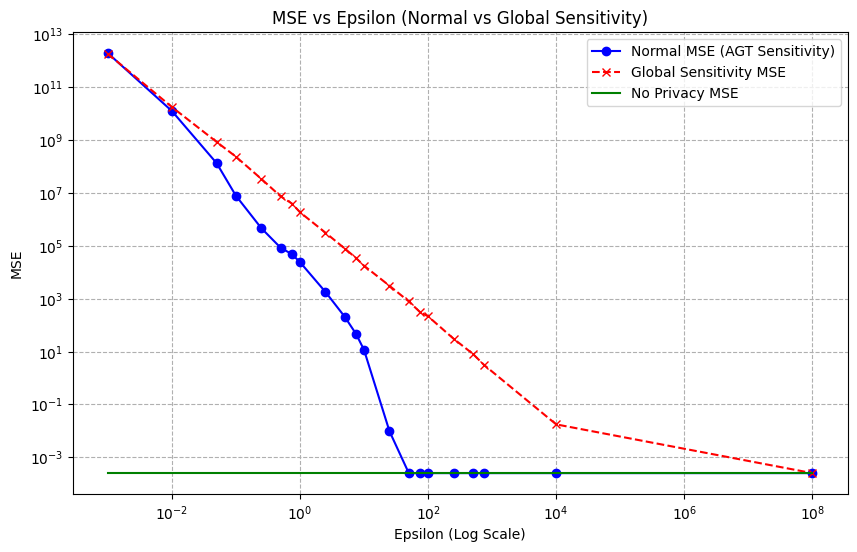

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Define the specific epsilon values
epsilon_values = [0.001, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 2.5, 5, 7.5, 10, 25, 50, 75, 100, 250, 500, 750, 10000, 100000000]

# Store results for both normal MSE and global sensitivity-based MSE
normal_mse_values = []
global_sensitivity_mse_values = []
no_privacy_mse_values = []

# Loop over epsilon values and calculate the MSE for each
for epsilon in epsilon_values:
    # Calculate the noise level using AGT smooth sensitivity bounds
    noise_level = privacy_utils_regression.get_calibrated_noise_level(
        dataset_test.tensors[0], privacy_bounded_models, min_bound=-27, max_bound=27, epsilon=epsilon, noise_type="cauchy"
    )
    
    ave = 0
    num = 1000
    for i in range(num):
        ave += noisy_test_mse(
            bounded_model, *dataset_test.tensors, noise_level=noise_level, noise_type="cauchy"
        )
    normal_mse = ave / (num * len(dataset_test))
    # print(f"Average MSE is {ave / (num * len(dataset_test))}")
    
    # Store normal MSE
    normal_mse_values.append(normal_mse)
    

    ave = 0
    num = 1000
    for i in range(num):
        ave += noisy_test_mse(
            bounded_model, *dataset_test.tensors, noise_level=6 * 54/epsilon, noise_type="cauchy"
        )
    
    global_mse = ave / (num * len(dataset_test))
    # Store global sensitivity MSE
    global_sensitivity_mse_values.append(global_mse)

    no_privacy_mse = noisy_test_mse(
            bounded_model, *dataset_test.tensors, noise_level=0, noise_type="none"
        ) / len(dataset_test)
    # Store global sensitivity MSE
    no_privacy_mse_values.append(no_privacy_mse)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot both MSE curves
plt.plot(epsilon_values, normal_mse_values, label="Normal MSE (AGT Sensitivity)", color="blue", marker='o')
plt.plot(epsilon_values, global_sensitivity_mse_values, label="Global Sensitivity MSE", color="red", linestyle="--", marker='x')
plt.plot(epsilon_values, no_privacy_mse_values, label="No Privacy MSE", color="green")

# Set x-axis to logarithmic scale
plt.xscale('log')

# Set y-axis to logarithmic scale
plt.yscale('log')

# Add labels and title
plt.xlabel('Epsilon (Log Scale)')
plt.ylabel('MSE')
plt.title('MSE vs Epsilon (Normal vs Global Sensitivity)')
plt.legend()

# Show the plot
plt.grid(True, which="both", ls="--")  # Add grid for both major and minor ticks
plt.show()


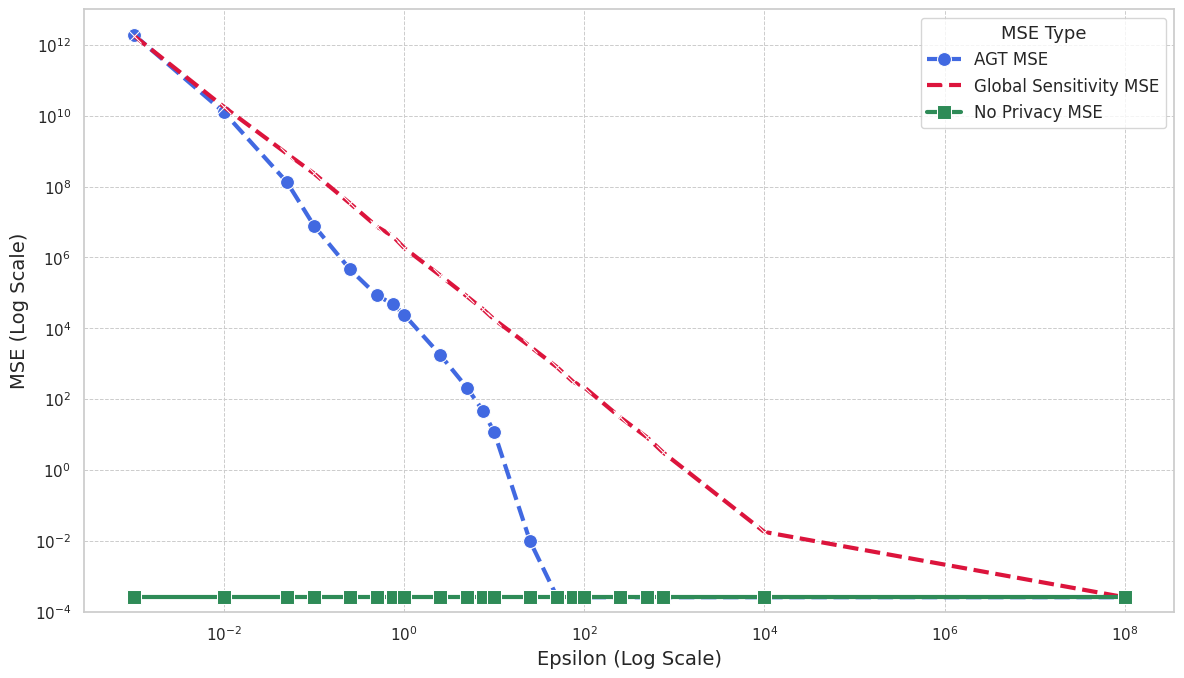

In [11]:
import seaborn as sns
# Apply a Seaborn theme
sns.set_theme(style="whitegrid")

# Create the figure
plt.figure(figsize=(12, 7))

# Plot MSE curves with enhanced styles
sns.lineplot(x=epsilon_values, y=normal_mse_values, label="AGT MSE", 
             marker='o', markersize=10, linestyle='--', color='royalblue', linewidth=3)

sns.lineplot(x=epsilon_values, y=global_sensitivity_mse_values, label="Global Sensitivity MSE", 
             marker='x', markersize=10, linestyle='--', color='crimson', linewidth=3)

sns.lineplot(x=epsilon_values, y=no_privacy_mse_values, label="No Privacy MSE", 
             marker='s', markersize=10, linestyle='-', color='seagreen', linewidth=3)

# Log scale for both axes
plt.xscale('log')
plt.yscale('log')

# Axis labels and title
plt.xlabel('Epsilon (Log Scale)', fontsize=14)
plt.ylabel('MSE (Log Scale)', fontsize=14)
# plt.title('MSE vs Epsilon under Different Privacy Settings', fontsize=16, fontweight='bold')

# Legend and grid
plt.legend(title='MSE Type', fontsize=12, title_fontsize=13, loc='best')
plt.grid(True, which="both", linestyle='--', linewidth=0.7)

# Tidy up layout
plt.tight_layout()

plt.ylim(1e-4, 1e13)

# Show plot
plt.show()